Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import ptitprince as pt
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from metadPy.hierarchical import hmetad
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
import arviz as az
from plotting import raincloud

sns.set_context('talk')

Import merged dataframe from behavioral data.

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

Filter trial level dataframe, discretize confidence rating and store results in a `metacognition_trials.txt` file.

In [69]:
metacognition_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    drop = []
    merged_df = pd.read_csv(path + f'/data/{session}_merged.txt')
    for sub in merged_df.Subject.unique():
        for cond in merged_df.Modality.unique():
            this_df = merged_df[(merged_df.Subject==sub) & (merged_df.Modality==cond)]

            # Drop NAs
            this_df = this_df[~this_df.Confidence.isnull()]
            
            # Remove HR outliers
            this_df = this_df[this_df.HeartRateOutlier==0]
            
            # Discretize ratings
            try:
                new_ratings, out = discreteRatings(this_df.Confidence.to_numpy(), verbose=False)
                this_df.loc[:, 'Confidence'] = new_ratings
                this_df['Session'] = session
                this_df['Stimuli'] = this_df['Alpha'] > 0
                this_df['Responses'] = this_df['Decision'] == 'More'
                this_df['Accuracy'] = (this_df['Stimuli'] & this_df['Responses']) | (~this_df['Stimuli'] & ~this_df['Responses'])
                this_df = this_df[['Subject', 'Session', 'Modality', 'Stimuli', 'Accuracy', 'Responses', 'Confidence']]
                metacognition_df = metacognition_df.append(this_df)
                
                if (this_df['Stimuli'].sum() == 0):
                    drop.append(sub)

            except ValueError:
                print(f'Dropping subject {sub} due to invalid ratings')
                drop.append(sub)
                
    for sub in drop:
        metacognition_df = metacognition_df[metacognition_df.Subject!=sub]

metacognition_df.to_csv(path + '/data/metacognition_trials.txt')

Dropping subject sub_0245 due to invalid ratings
Dropping subject sub_0084 due to invalid ratings


Extract d prime and criterion in `sdt_df` and save response ratings in `responsesRatings_df`.

In [102]:
sdt_df = pd.DataFrame([])
responsesRatings_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    for sub in metacognition_df[metacognition_df.Session==session].Subject.unique():
        for cond in metacognition_df.Modality.unique():
            this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Session==session) & (metacognition_df.Modality==cond)]
                    
            nR_S1, nR_S2 = trials2counts(
                data=this_df, stimuli='Stimuli', accuracy='Accuracy',
                confidence='Confidence', nRatings=4)

            responsesRatings_df = responsesRatings_df.append(pd.DataFrame({
                'Subject': sub, 'Modality': cond, 'Session': session, 'nR_S1': nR_S1, 'nR_S2': nR_S2}))

            sdt_df = sdt_df.append(pd.DataFrame({
                'Subject': [sub],
                'Session': session,
                'Modality': [cond],
                'RespCountS1': nR_S1.sum(),
                'RespCountS2': nR_S2.sum(),
                'Accuracy': this_df.Accuracy.to_numpy().mean() * 100,
                'd': [this_df.dprime()],
                'c': [this_df.criterion()]}))

Drop participants whose values for d-prime are outside 1.5 times the interquartile range.

In [5]:
for cond in sdt_df.Condition.unique():
    this_df = sdt_df[(sdt_df.Condition==cond)]

    q1 = this_df['d'].quantile(.25)
    q3 = this_df['d'].quantile(.75)

    for sub in this_df.Subject[this_df['d'] > this_df['d'].quantile(.75) + ((q3 - q1) * 1.5)]:
        print(f'Drop {sub}')
        responsesRatings_df = responsesRatings_df[responsesRatings_df.Subject!=sub]
        sdt_df = sdt_df[sdt_df.Subject!=sub]

    for sub in this_df.Subject[this_df['d'] < this_df['d'].quantile(.25) - ((q3 - q1) * 1.5)]:
        print(f'Drop {sub}')
        responsesRatings_df = responsesRatings_df[responsesRatings_df.Subject!=sub]
        sdt_df = sdt_df[sdt_df.Subject!=sub]

Drop sub_0228


In [103]:
responsesRatings_df.to_csv(path + '/data/responsesRatings.txt')

# d prime and criterion

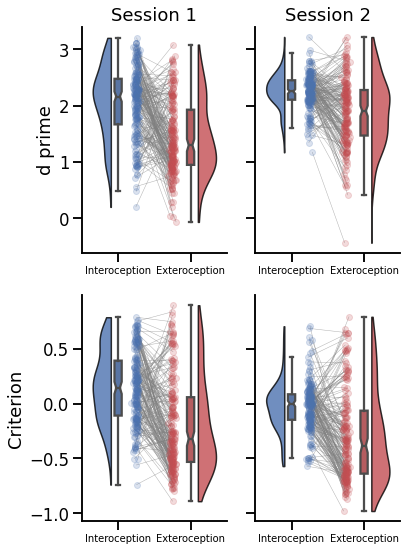

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(6, 8), sharey='row')
for i, metric in enumerate(['d', 'c']):
    for ii, session in enumerate(['Del1', 'Del2']):
        raincloud(data=sdt_df[(sdt_df.Session==session)], x='Modality', y=metric, ax=axs[i, ii], palette=['#4c72b0', '#c44e52'])
        labels = [item.get_text() for item in axs[i, ii].get_xticklabels()]
        labels[0] = 'Interoception'
        labels[1] = 'Exteroception'
        axs[i, ii].set_xticklabels(labels, size=10)

axs[0, 0].set_title('Session 1')
axs[0, 1].set_title('Session 2')
axs[0, 0].set_ylabel('d prime')
axs[1, 0].set_ylabel('Criterion')
plt.tight_layout()
sns.despine()

In [78]:
sdt_df[sdt_df.Session == 'Del1']

,Subject,Session,Modality,RespCountS1,RespCountS2,Accuracy,d,c
0,sub_0019,Del1,Extero,39,41,81.250000,1.774720,-0.063918
0,sub_0019,Del1,Intero,11,46,56.140351,1.581421,0.899911
0,sub_0020,Del1,Extero,26,54,68.750000,1.116642,0.177995
0,sub_0020,Del1,Intero,64,5,60.869565,1.478651,-0.542226
0,sub_0022,Del1,Extero,43,36,87.341772,2.366047,-0.199971
...,...,...,...,...,...,...,...,...
0,sub_0254,Del1,Intero,38,32,77.142857,1.492919,-0.029962
0,sub_0255,Del1,Extero,36,44,80.000000,1.687129,0.018070
0,sub_0255,Del1,Intero,60,1,52.459016,0.041789,0.020895
0,sub_0256,Del1,Extero,11,68,60.759494,1.093825,0.361545


In [79]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del1'], dv='d', within='Modality', subject='Subject', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,True,True,9.535699,202.0,two-sided,4.960834e-18,1.014e+15,0.985019


In [80]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del1'], dv='c', within='Modality', subject='Subject', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,True,True,9.636034,202.0,two-sided,2.543439e-18,1.951e+15,0.919707


In [81]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del2'], dv='d', within='Modality', subject='Subject', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,True,True,7.983477,185.0,two-sided,1.460564e-13,4.459e+10,0.775682


In [82]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del2'], dv='c', within='Modality', subject='Subject', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,True,True,9.010614,185.0,two-sided,2.531869e-16,2.204e+13,0.849237


# Raw confidence ratings

In [94]:
rawConfidence_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    for sub in metacognition_df.Subject.unique():
        for cond in metacognition_df.Modality.unique():
            for corr in [True, False]:
                this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Modality==cond) & (metacognition_df.Session==session) & (metacognition_df.Accuracy==corr)]
                new_ratings = this_df.Confidence.to_numpy()
                rawConfidence_df = rawConfidence_df.append(pd.DataFrame({
                    'Subject': sub,
                    'Session': session,
                    'Modality': cond,
                    'Correct': corr,
                    'Ratings': np.arange(1, 5),
                    'Density': np.array([np.count_nonzero(new_ratings == i) for i in range(1, 5)]) / len(new_ratings)}), ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


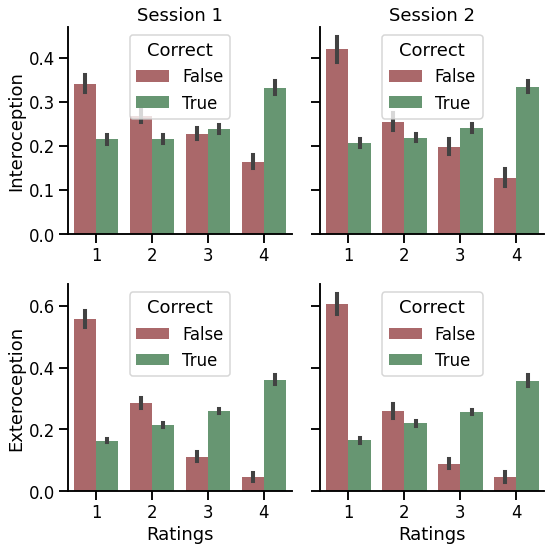

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey='row')
for i, cond in enumerate(['Intero', 'Extero']):
    for ii, session in enumerate(['Del1', 'Del2']):
        sns.barplot(data=rawConfidence_df[(rawConfidence_df.Modality==cond) & (rawConfidence_df.Session==session)], x='Ratings', y='Density', hue='Correct', ax=axs[i, ii], palette=["#b55d60", "#5f9e6e"])
        labels = [item.get_text() for item in axs[i, ii].get_xticklabels()]

axs[0, 0].set_title('Session 1')
axs[0, 1].set_title('Session 2')
axs[0, 0].set_ylabel('Interoception')
axs[1, 0].set_ylabel('Exteroception')
axs[0, 1].set_ylabel('')
axs[1, 1].set_ylabel('')
axs[0, 0].set_xlabel('')
axs[0, 1].set_xlabel('')
plt.tight_layout()
sns.despine()

# Fitting meta-d model using JAGS

## Repeated measures model

In [43]:
samples = pd.read_csv(path + '/data/jagsSamples.txt', sep='\t')

In [52]:
stats = pd.read_csv(path + '/data/jagsStats.txt', sep='\t')
stats['Condition'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Condition'] = 'Extero'
for sub in range(1, 217):
    stats.loc[stats.name.str.contains(str(sub)+','), 'Subject'] = [str(sub)]
stats = stats[stats.name.str.contains('Mratio')]
#stats = stats.sort_values('Condition')

Remove outliers (m-ratio > 3)

In [29]:
for sub in stats.Subject[(stats['Condition']=='Intero') & (stats['mean']>3)]:
    stats = stats[stats.Subject!=sub]
    print(f'Subject {responsesRatings_df.Subject.unique()[int(sub)]} removed')

Subject sub_0224 removed
Subject sub_0197 removed


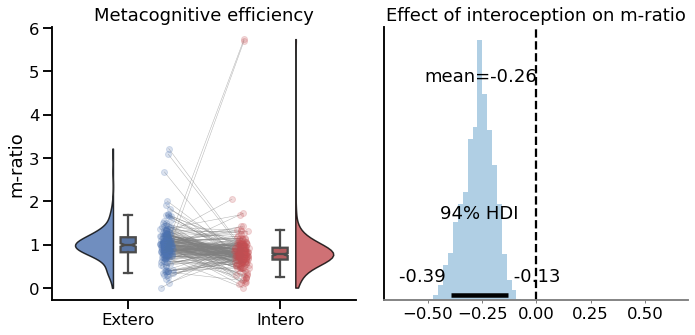

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

raincloud(data=stats, x='Condition', y='mean', ax=axs[0])
axs[0].set_title('Metacognitive efficiency')
axs[0].set_ylabel('m-ratio')
axs[0].set_xlabel('')
sns.despine()

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1])
axs[1].axvline(x=0, linestyle='--', color='k')
axs[1].set_xlim(-.7, .7)
axs[1].set_title('Effect of interoception on m-ratio')
sns.despine()

plt.tight_layout()
plt.savefig(path + '/figures/Fig3_betas_mratio.svg', dpi=600)

## Subject level fits

Comparison between the Hmeta-d toolbox and metadPy

In [70]:
metadprimeR_df = pd.read_csv(path + '/data/metadprimeHmetad.txt', sep='\t')
metadprimePy_df = pd.read_csv(path + '/data/metadprimeMetadPy.txt')
summary_df = pd.merge(metadprimeR_df, metadprimePy_df, on=['Subject', 'Condition'])

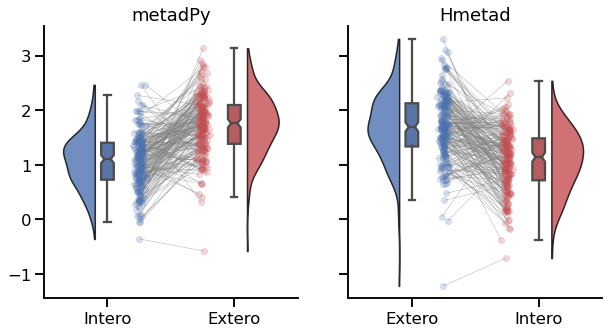

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
raincloud(data=metadprimePy_df, x='Condition', y='mean', ax=axs[0])
raincloud(data=metadprime_df, x='Condition', y='MetadPrime', ax=axs[1])
axs[0].set_title('metadPy')
axs[1].set_title('Hmetad')
sns.despine()

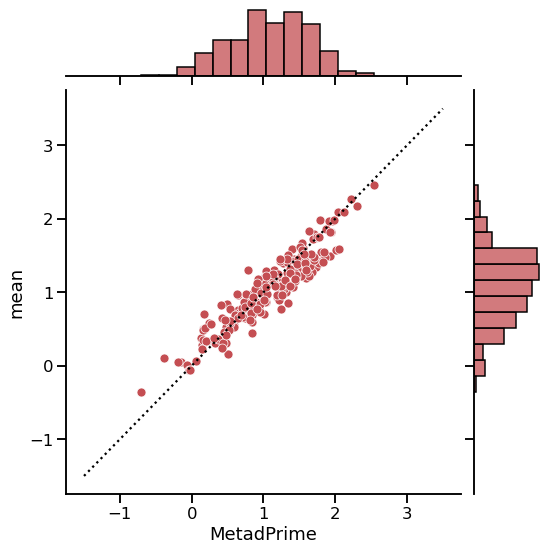

In [80]:
g = sns.jointplot(data=summary_df[summary_df.Condition=='Intero'], x='MetadPrime', y='mean', color='#c44e52', height=8)
lims = [-1.5, 3.5]
g.ax_joint.plot(lims, lims, ':k')

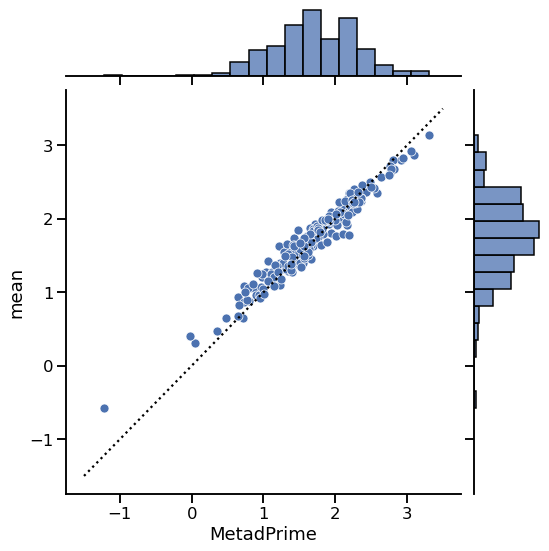

In [81]:
g = sns.jointplot(data=summary_df[summary_df.Condition=='Extero'], x='MetadPrime', y='mean', color='#4c72b0', height=8)
lims = [-1.5, 3.5]
g.ax_joint.plot(lims, lims, ':k')

# Repeated measure model

In [29]:
trace = az.from_netcdf(path + '/data/metacognition')

In [30]:
stats_metadPy = az.summary(trace, var_names=['mRatio'], round_to=2)

In [32]:
stats_metadPy['Condition'] = 'Intero'
stats_metadPy.loc[stats_metadPy.index.str.contains("1,0]"), 'Condition'] = 'Extero'
stats_metadPy['Subject'] = np.repeat(np.arange(0, 212), 2)

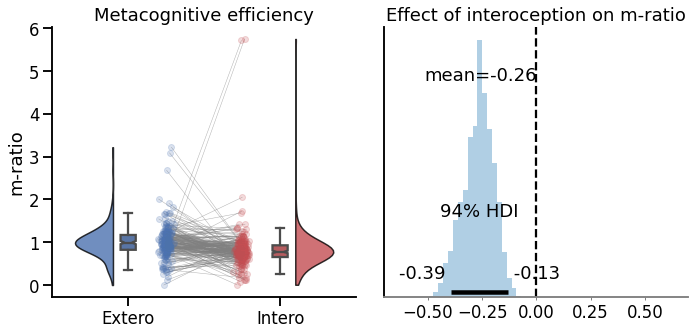

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

raincloud(data=stats, x='Condition', y='mean', ax=axs[0])
axs[0].set_title('Metacognitive efficiency')
axs[0].set_ylabel('m-ratio')
axs[0].set_xlabel('')
sns.despine()

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1])
axs[1].axvline(x=0, linestyle='--', color='k')
axs[1].set_xlim(-.7, .7)
axs[1].set_title('Effect of interoception on m-ratio')
sns.despine()

plt.tight_layout()
plt.savefig(path + '/figures/Fig3_betas_mratio.svg', dpi=600)

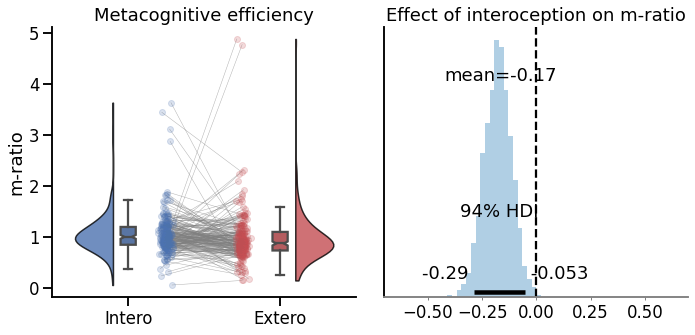

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

raincloud(data=stats_metadPy, x='Condition', y='mean', ax=axs[0])
axs[0].set_title('Metacognitive efficiency')
axs[0].set_ylabel('m-ratio')
axs[0].set_xlabel('')
sns.despine()

az.plot_posterior(trace, var_names=['mu_Cond1'], kind='hist', bins=20, ax=axs[1])
axs[1].axvline(x=0, linestyle='--', color='k')
axs[1].set_xlim(-.7, .7)
axs[1].set_title('Effect of interoception on m-ratio')
sns.despine()

plt.tight_layout()
plt.savefig(path + '/figures/Fig3_betas_mratio.svg', dpi=600)

In [36]:
stats_metadPy

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,Condition,Subject
"mRatio[0,0,0]",1.24,0.26,0.82,1.74,0.01,0.01,649.87,649.87,644.83,1723.84,1.00,Intero,0
"mRatio[0,1,0]",0.80,0.25,0.30,1.26,0.01,0.00,1586.35,1586.35,1515.77,1796.77,1.00,Extero,0
"mRatio[1,0,0]",1.70,0.43,0.95,2.47,0.02,0.01,788.15,788.15,781.40,1028.74,1.01,Intero,1
"mRatio[1,1,0]",1.22,0.41,0.55,2.02,0.02,0.01,556.55,556.55,555.72,1200.78,1.00,Extero,1
"mRatio[2,0,0]",1.17,0.20,0.83,1.55,0.01,0.01,591.82,591.82,584.75,1273.01,1.01,Intero,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"mRatio[209,1,0]",0.59,0.25,0.09,0.98,0.01,0.01,767.98,686.30,764.81,1662.72,1.01,Extero,209
"mRatio[210,0,0]",1.40,0.30,0.89,1.96,0.01,0.01,546.79,544.68,566.14,1220.13,1.01,Intero,210
"mRatio[210,1,0]",1.22,0.52,0.41,2.29,0.03,0.02,400.77,400.77,422.97,897.18,1.00,Extero,210
"mRatio[211,0,0]",1.82,0.60,0.83,2.90,0.03,0.02,425.76,425.76,412.95,885.85,1.00,Intero,211


In [66]:
stats

,name,mean,Condition,Subject
1,"Mratio[1,1]",0.712249,Intero,1
2,"Mratio[2,1]",0.969965,Intero,2
3,"Mratio[3,1]",0.867480,Intero,3
4,"Mratio[4,1]",0.701454,Intero,4
5,"Mratio[5,1]",0.465672,Intero,5
...,...,...,...,...
418,"Mratio[207,2]",1.004314,Extero,207
419,"Mratio[208,2]",1.121055,Extero,208
420,"Mratio[209,2]",0.847531,Extero,209
421,"Mratio[210,2]",1.366319,Extero,210


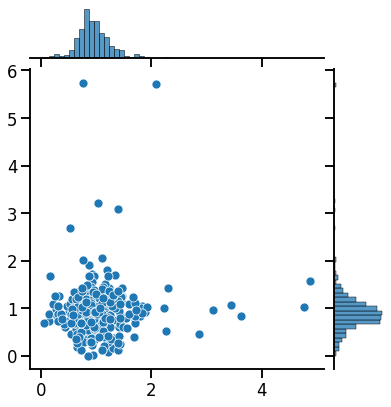

In [64]:
sns.jointplot(x=stats_metadPy['mean'].to_numpy()[:-2], y=stats['mean'].to_numpy())